In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from scipy.optimize import minimize

plt.style.use("dark_background")

/home/sngflu/IT/myvenv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
X, y = make_classification(n_samples=500, n_features=2, n_classes=2, n_informative=2, n_redundant=0, flip_y=0.1)
y = 2 * y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
class SVM:
    """
    Класс для реализации метода опорных векторов (SVM) с различными типами ядер.

    Параметры:
        kernel (str): Тип ядра. Возможные значения: "linear", "rbf", "polynomial". По умолчанию "linear".
        C (float): Параметр регуляризации. По умолчанию 1.0.
        degree (int): Степень полиномиального ядра. По умолчанию 3.
        gamma (float): Параметр для RBF ядра. По умолчанию 0.1.
    """

    def __init__(self, kernel="linear", C=1.0, degree=3, gamma=0.1):
        # инициализация параметров класса
        self.kernel = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma

    def _linear_kernel(self, X, Y):
        """
        Вычисляет линейное ядро.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            Y (numpy.ndarray): Матрица признаков.

        Возвращает:
            numpy.ndarray: Линейное ядро.
        """
        return X @ Y.T  # вычисление линейного ядра

    def _rbf_kernel(self, X, Y):
        """
        Вычисляет RBF (радиально-базисное функциональное) ядро.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            Y (numpy.ndarray): Матрица признаков.

        Возвращает:
            numpy.ndarray: RBF ядро.
        """
        pairwise_sq_dists = np.sum(X**2, axis=1)[:, None] + np.sum(Y**2, axis=1)[None, :] - 2 * X @ Y.T  # параллельные квадратные расстояния
        return np.exp(-self.gamma * pairwise_sq_dists)  # вычисление RBF ядра

    def _polynomial_kernel(self, X, Y):
        """
        Вычисляет полиномиальное ядро.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            Y (numpy.ndarray): Матрица признаков.

        Возвращает:
            numpy.ndarray: Полиномиальное ядро.
        """
        return (X @ Y.T + 1) ** self.degree  # вычисление полиномиального ядра

    def _compute_kernel(self, X, Y=None):
        """
        Вычисляет ядро в зависимости от выбранного типа.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            Y (numpy.ndarray): Матрица признаков. По умолчанию None.

        Возвращает:
            numpy.ndarray: Вычисленное ядро.
        """
        if Y is None:
            Y = X  # если Y не задано, используем X
        if self.kernel == "linear":
            return self._linear_kernel(X, Y)  # вычисление линейного ядра
        elif self.kernel == "rbf":
            return self._rbf_kernel(X, Y)  # вычисление RBF ядра
        elif self.kernel == "polynomial":
            return self._polynomial_kernel(X, Y)  # вычисление полиномиального ядра

    def fit(self, X, y):
        """
        Обучает модель SVM на данных.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.
        """
        self.X = X  # сохранение признаков
        self.y = y  # сохранение меток
        n_samples, _ = X.shape  # количество образцов

        K = self._compute_kernel(X)  # вычисление ядра

        def objective(alpha):
            """
            Целевая функция для минимизации.

            Параметры:
                alpha (numpy.ndarray): Вектор альфа.

            Возвращает:
                float: Значение целевой функции.
            """
            return -np.sum(alpha) + 0.5 * np.sum(
                np.outer(alpha, alpha) * np.outer(y, y) * K
            )

        constraints = [
            {"type": "eq", "fun": lambda alpha: np.dot(alpha, y)},  # ограничение на сумму альфа
            {"type": "ineq", "fun": lambda alpha: alpha},  # ограничение на неотрицательность альфа
            {"type": "ineq", "fun": lambda alpha: self.C - alpha},  # ограничение на максимальное значение альфа
        ]

        alpha0 = np.zeros(n_samples)  # начальное значение альфа

        result = minimize(objective, alpha0, constraints=constraints)  # минимизация целевой функции
        self.alpha = result.x  # сохранение оптимальных альфа

        support_indices = self.alpha > 1e-5  # индексы опорных векторов
        self.support_vectors = X[support_indices]  # опорные векторы
        self.support_labels = y[support_indices]  # метки опорных векторов
        self.support_alpha = self.alpha[support_indices]  # альфа опорных векторов

        self.w = None  # инициализация весов
        if self.kernel == "linear":
            self.w = np.sum(
                (self.support_alpha * self.support_labels)[:, None] * self.support_vectors,
                axis=0,
            )  # вычисление весов для линейного ядра

        self.b = np.mean(
            [
                y_i - np.sum(self.support_alpha * self.support_labels * K[idx, support_indices])
                for idx, y_i in enumerate(y[support_indices])
            ]
        )  # вычисление смещения

    def predict(self, X):
        """
        Предсказывает метки для данных.

        Параметры:
            X (numpy.ndarray): Матрица признаков.

        Возвращает:
            numpy.ndarray: Предсказанные метки.
        """
        if self.kernel == "linear":
            return np.sign(X @ self.w + self.b)  # предсказание для линейного ядра
        else:
            K = self._compute_kernel(X, self.support_vectors)  # вычисление ядра
            return np.sign(
                np.sum(self.support_alpha * self.support_labels * K, axis=1) + self.b
            )  # предсказание для нелинейных ядер

    def visualize(self, X, y, title):
        """
        Визуализирует границу решений и данные.

        Параметры:
            X (numpy.ndarray): Матрица признаков.
            y (numpy.ndarray): Вектор меток.
            title (str): Заголовок графика.
        """
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # границы по оси X
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # границы по оси Y
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))  # создание сетки

        grid_points = np.c_[xx.ravel(), yy.ravel()]  # точки сетки
        if X.shape[1] > 2:
            grid_points_full = np.zeros((grid_points.shape[0], X.shape[1]))  # инициализация полной матрицы точек сетки
            grid_points_full[:, :2] = grid_points  # заполнение первых двух признаков
            grid_points = grid_points_full  # обновление точек сетки

        Z = self.predict(grid_points)  # предсказание для точек сетки
        Z = Z.reshape(xx.shape)  # преобразование предсказаний в форму сетки

        plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#ff7f50', '#008080']))  # визуализация границы решений
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#ff8f61', '#119191']), edgecolor='k')  # визуализация данных
        plt.title(title)  # заголовок графика
        plt.show()  # отображение графика

CPU times: user 13.2 s, sys: 543 ms, total: 13.8 s
Wall time: 13.8 s
Custom Linear Accuracy: 0.86


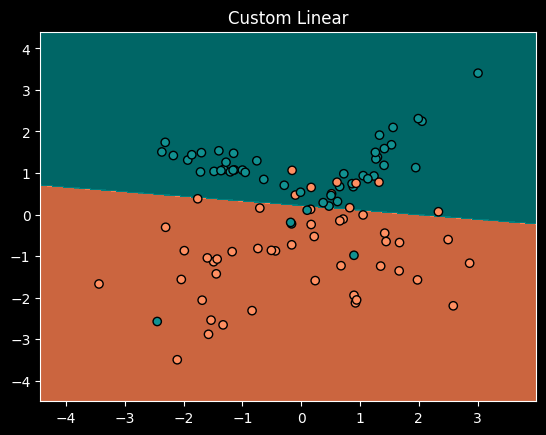

CPU times: user 23.4 s, sys: 798 ms, total: 24.2 s
Wall time: 23.5 s
Custom RBF Accuracy: 0.87


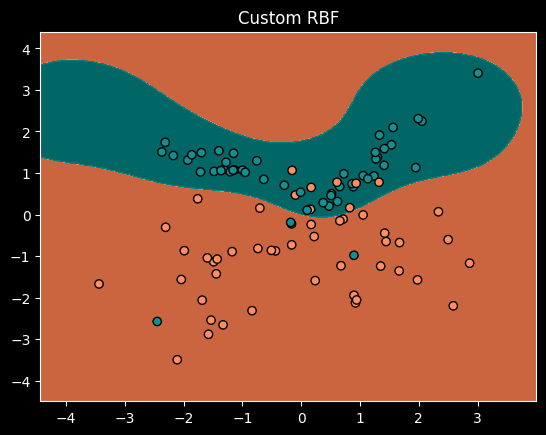

CPU times: user 21.1 s, sys: 35.5 ms, total: 21.1 s
Wall time: 21.2 s
Custom Polynomial Accuracy: 0.83


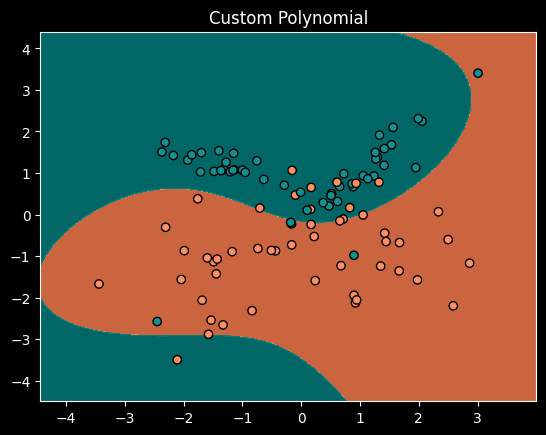

In [4]:
svm = SVM(kernel="linear", C=1.0)
%time svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Custom Linear Accuracy:", accuracy_score(y_test, y_pred))
svm.visualize(X_test, y_test, title="Custom Linear")

svm_rbf = SVM(kernel="rbf", C=1.0, gamma=0.5)
%time svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("Custom RBF Accuracy:", accuracy_score(y_test, y_pred_rbf))
svm_rbf.visualize(X_test, y_test, title="Custom RBF")

svm_poly = SVM(kernel="polynomial", C=1.0, degree=3)
%time svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("Custom Polynomial Accuracy:", accuracy_score(y_test, y_pred_poly))
svm_poly.visualize(X_test, y_test, title="Custom Polynomial")

In [5]:
sklearn_svm_linear = SVC(kernel="linear", C=1.0)
%time sklearn_svm_linear.fit(X_train, y_train)
sklearn_y_pred = sklearn_svm_linear.predict(X_test)
print("Sklearn Linear Accuracy:", accuracy_score(y_test, sklearn_y_pred))

sklearn_svm_rbf = SVC(kernel="rbf", C=1.0, gamma=0.5)
%time sklearn_svm_rbf.fit(X_train, y_train)
sklearn_y_pred_rbf = sklearn_svm_rbf.predict(X_test)
print("Sklearn RBF Accuracy:", accuracy_score(y_test, sklearn_y_pred_rbf))

sklearn_svm_poly = SVC(kernel="poly", C=1.0, degree=3)
%time sklearn_svm_poly.fit(X_train, y_train)
sklearn_y_pred_poly = sklearn_svm_poly.predict(X_test)
print("Sklearn Polynomial Accuracy:", accuracy_score(y_test, sklearn_y_pred_poly))

CPU times: user 3.96 ms, sys: 206 µs, total: 4.17 ms
Wall time: 2.97 ms
Sklearn Linear Accuracy: 0.83
CPU times: user 1.56 ms, sys: 904 µs, total: 2.47 ms
Wall time: 2.48 ms
Sklearn RBF Accuracy: 0.87
CPU times: user 2.02 ms, sys: 5 µs, total: 2.02 ms
Wall time: 2.02 ms
Sklearn Polynomial Accuracy: 0.83


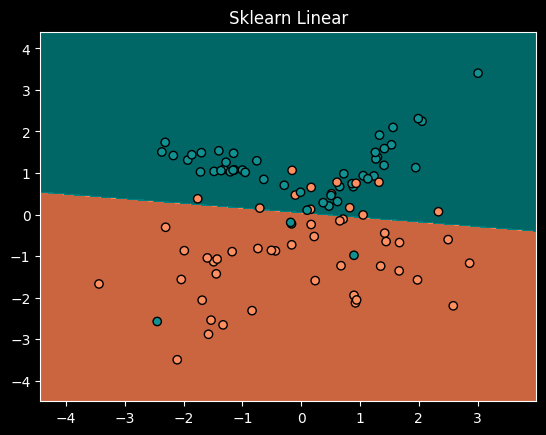

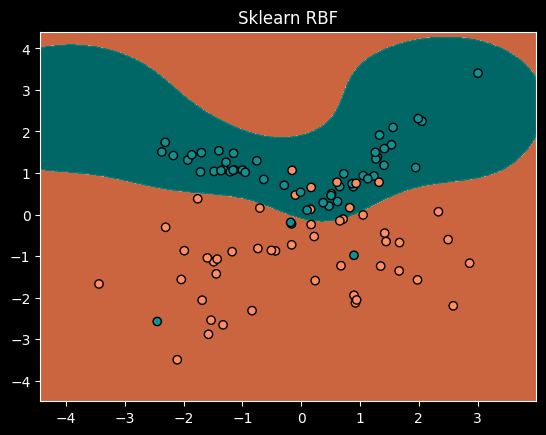

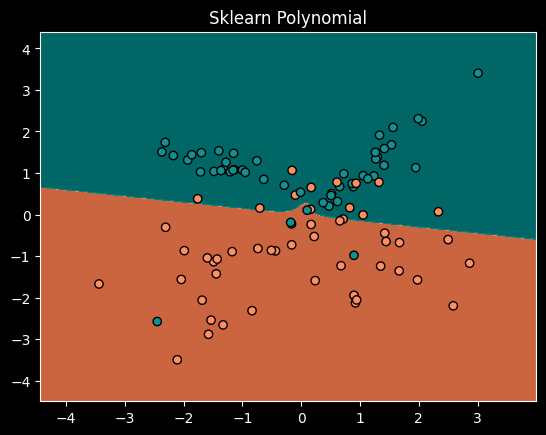

In [6]:
def sklearn_visualize(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#ff7f50', '#008080']))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#ff8f61', '#119191']), edgecolor='k')
    plt.title(title)
    plt.show()

sklearn_visualize(sklearn_svm_linear, X_test, y_test, title="Sklearn Linear")
sklearn_visualize(sklearn_svm_rbf, X_test, y_test, title="Sklearn RBF")
sklearn_visualize(sklearn_svm_poly, X_test, y_test, title="Sklearn Polynomial")